#### Import all the required packages

In [1]:
## basic packages
import numpy as np
import re
import csv
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [2]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix

In [3]:
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])
show_descriptions_aggregated = shows.apply(lambda x: x.show_description.unique()[0])
episode_descriptions_aggregated = shows.apply(lambda x: list(x.episode_description))

In [4]:
descriptions_aggregated = {}
for k,text in enumerate(episode_descriptions_aggregated):
    descriptions_aggregated[show_names[k]] = [show_descriptions_aggregated[k]]+text

In [5]:
genres_topics = ["comedy","news","crime","science","economics","politics","education",\
                  "sports","lifestyle","health","wellbeing","religion","faith","music",\
                  "art","fashion","literature","humanities","drama","fitness","drama",\
                  "fantasy","scifi","gameshow","news quiz","games","game","mental",\
                  "humor","research","technology","society","social","culture","lifestyle",\
                  "songs","cooking","culinary","food","travel","films","film","movies","tv",\
                  "climate","space","planet","digital","artificial intelligence", "ai",\
                  "cars","car","nutrition","wellness","family","history","geography","physics",\
                  "mathematics","math","chemistry","biology","documentary","commentary","nfl",\
                  "mls","nba","mlb","stocks","stock","market","wall","street","wallstreet","business",\
                  "reality","shows","investing","social media","biography","biographies",\
                  "data science","medicine","media","books","book","europe","asia","canada",\
                  "south america","north america","america","usa","netflix","adventure","pets","dogs",\
                  "cats","dog","cat","nintendo","xbox","playstation","ps4","ps5","theatre","mars"\
                  "tennis","australia","conspiracy","war","epidemic","pandemic","climate","change"\
                  "astrology","novel","church","christ","romance","english","kids","astronomy"\
                  "design","entrepreneurship","marketing","digital","christian","christianity","boardgames",\
                  "boardgame","videogames","videogame","twitch","currency","cryptocurrency","federal","bank",\
                  "blockchain","bitcoin","nyse","nft","import","export","capital","money","exchange","boxing",\
                  "mma","wrestling","excercise","excercises","gym","bodybuilding","body-building","yoga",\
                  "stamina","strength","calories","meditation","physical","healthy","pope","bible","catholic",\
                  "catholicism","testament"]

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

In [6]:
podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [7]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yea','yep','yes','no',\
                                "like","oh","yeah","okay","wow","podcast","rating","ratings","not",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "somebody","anybody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

In [8]:
health_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("fitness" in val)\
                                                                or ("health" in val)\
                                                                or ("diet" in val)\
                                                                or ("nutrition" in val)\
                                                                or ("healthy" in val)\
                                                                or ("meditation" in val)\
                                                                or ("mental" in val)\
                                                                or ("physical" in val)\
                                                                or ("excercise" in val)\
                                                                or ("calories" in val)\
                                                                or ("gym" in val)\
                                                                or ("bodybuilding" in val)\
                                                                or ("body-building" in val)\
                                                                or ("stamina" in val)\
                                                                or ("strength" in val)\
                                                                or ("excercise" in val)\
                                                                or ("yoga" in val)]

In [9]:
sports_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("sports" in val)\
                                                            or ("games" in val)\
                                                            or ("game" in val)\
                                                            or ("videogame" in val)\
                                                            or ("videogames" in val)\
                                                            or ("boardgame" in val)\
                                                            or ("boardgames" in val)\
                                                            or ("xbox" in val)\
                                                            or ("nintendo" in val)\
                                                            or ("twitch" in val)\
                                                            or ("ps4" in val)\
                                                            or ("ps5" in val)\
                                                            or ("playstation" in val)\
                                                            or ("basketball" in val)\
                                                            or ("football" in val)\
                                                            or ("soccer" in val)\
                                                            or ("baseball" in val)\
                                                            or ("boxing" in val)\
                                                            or ("wrestling" in val)\
                                                            or ("mma" in val)\
                                                            or ("tennis" in val)]

In [8]:
religion_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("religion" in val)\
                                                            or ("faith" in val)\
                                                            or ("church" in val)\
                                                            or ("christ" in val)\
                                                            or ("christian" in val)\
                                                            or ("christianity" in val)\
                                                            or ("bible" in val)\
                                                            or ("testament" in val)\
                                                            or ("pope" in val)\
                                                            or ("catholic" in val)\
                                                            or ("catholicism" in val)]

In [11]:
invest_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("market" in val)\
                                                            or ("business" in val)\
                                                            or ("invest" in val)\
                                                            or ("stocks" in val)\
                                                            or ("stock" in val)\
                                                            or ("wallstreet" in val)\
                                                            or ("investing" in val)\
                                                            or ("investment" in val)\
                                                            or ("exchange" in val)\
                                                            or ("nyse" in val)\
                                                            or ("capital" in val)\
                                                            or ("money" in val)\
                                                            or ("currency" in val)\
                                                            or ("cryptocurrency" in val)\
                                                            or ("blockchain" in val)\
                                                            or ("bitcoin" in val)\
                                                            or ("federal" in val)\
                                                            or ("bank" in val)\
                                                            or ("nft" in val)]

In [46]:
number_of_topics = [5,6,7,8,9,10,15]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
sports_cs = []
with open('/home1/sgmark/capstone-project/model/coherence_scores_religion_category.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        sports_cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[5] for x in sports_cs])]

In [47]:
best_hp_setting

(5, (6, 0.9))

#### The individual transcript location

In [13]:
def file_location(show,episode):
    search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
                               + "/" + show[0] \
                               + "/" + show[1] \
                               + "/" + "show_" + show \
                               + "/"
    return search_string

#### load the transcripts

In [14]:
transcripts = {}
for podcast,genre in religion_category:
    for i in shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('../podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [15]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

# # lemmatization -- do lemmatization for just the verbs
# def get_lemmatized(text):
#     lemmatized = []
#     for phrase in text:
#         sentence=''
#         for word in nlp(phrase):
#             if word.pos_ == "VERB":
#                 #or word.pos_ == "ADJ" or word.pos_ == "ADV":
#                 sentence += ' ' + str(word.lemma_)
#             elif str(word)!='':
#                 sentence += ' ' + str(word)
#         lemmatized.append(sentence.strip())
#     return lemmatized

# def get_named_entities(text):
#     return nlp(text.lower()).ents

# def get_noun_chunks(text):
#     non_stop_noun_chunks = []
#     stops = stopwords.words("english")
#     for word in nlp(text.lower()).noun_chunks:
#         if str(word) not in stops:
#             non_stop_noun_chunks.append(word)
#     return non_stop_noun_chunks

#### tokenize/convert text into words

In [48]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [49]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))

In [50]:
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [51]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

#### Construct a corpus of words as a bag of words 

In [52]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [53]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# from itertools import product

# number_of_topics = [5,6,7,8,9,10,15]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 200
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores_religion_category.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

In [54]:
%%time
import logging
logging.basicConfig(filename='religion_topics.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = best_hp_setting[0]
chunksize = 200
passes = 50
iterations = 500
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

CPU times: user 31.8 s, sys: 19.8 ms, total: 31.8 s
Wall time: 31.8 s


In [24]:
top_topics = lda_model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics

print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -0.8268.


In [55]:
cm = CoherenceModel(lda_model, texts = texts, corpus=corpus, coherence='c_npmi')
coherence = cm.get_coherence() 
print(coherence)
for x in cm.get_coherence_per_topic(): print(x)

0.02942897361518566
0.010920267325592833
0.017413806749319347
0.030864923889938962
0.017170672600274106
0.07077519751080304


### Visualizing data

In [61]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_html(vis,'religion_umass.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.118996 -0.114728       1        1  32.626863
2     -0.026924 -0.005080       2        1  23.750467
0     -0.118775 -0.212429       3        1  17.895088
1     -0.138335  0.153011       4        1  17.727993
4      0.165038  0.179227       5        1   7.999589, topic_info=           Term         Freq        Total Category  logprob  loglift
85         lord  3919.000000  3919.000000  Default  20.0000  20.0000
70        jesus  7647.000000  7647.000000  Default  19.0000  19.0000
1749     daniel   766.000000   766.000000  Default  18.0000  18.0000
19      chapter  1831.000000  1831.000000  Default  17.0000  17.0000
150        word  3302.000000  3302.000000  Default  16.0000  16.0000
...         ...          ...          ...      ...      ...      ...
675      heaven   190.437837   940.810864   Topic5  -5.1952   0.9284
14        bible   233.698303  2680.081013   Topic5  -4.9905   0.0862
70        jesus   266.075575  7647.672190   Topic5  -4.8607  -0.8326
559        tree   155.739651   444.703937   Topic5  -5.3963   1.4766
180   authority   151.687443   826.232840   Topic5  -5.4227   0.8307

[286 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5686      5  0.992703   abednego
152       1  0.621930       able
152       2  0.192890       able
152       3  0.108914       able
152       4  0.052930       able
...     ...       ...        ...
1564      1  0.034744    youtube
1564      2  0.034744    youtube
1564      3  0.889456    youtube
1564      5  0.041693    youtube
4193      4  0.982243  zacharias

[591 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

In [ ]:
# from pprint import pprint
# pprint(top_topics)

In [57]:
import pickle

pickle.dump(lda_model,open('../model/religion_episodes_lda_model_umass.pkl','wb'))
pickle.dump(dictionary,open('../model/religion_episodes_dictionary_umass.pkl','wb'))
pickle.dump(corpus,open('../model/religion_episodes_corpus_umass.pkl','wb'))
# pickle.dump(texts,open('../model/religion_episodes_texts.pkl','wb'))

In [ ]:
# import pickle

# file = open('../model/religion_episodes_lda_model.pkl','rb')
# lda_model = pickle.load(file)
# file.close()

# file = open('../model/religion_episodes_corpus.pkl','rb')
# corpus = pickle.load(file)
# file.close()

# file = open('../model/religion_episodes_dictionary.pkl','rb')
# dictionary = pickle.load(file)
# file.close()

In [58]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode')], axis=1)

    return result_df

In [59]:
main_topic_df = get_main_topic_df(lda_model,corpus,texts)
main_topic_df.to_pickle('religion_topics_main_df_umass.pkl')

In [60]:
main_topic_df.head(5)

,show_filename_prefix,episode_filename_prefix,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show,Description of the episode
0,show_5UDp5vs6yQFsS32Kad024Z,2NJVZEMS9qaGBzLA1ehAlU,8-Minute Bible Study with Saint Andrew,BIBLE CHATS 01 : John 21 - The Two Greek Words...,2,0.617,"[creation, record, edit, right, phone, compute...",christ church gospel jesus kind love paul rela...,10.037983333333333,Andrew Lau,The Bible Chats Series feature episodes where ...
1,show_5HkyYFcQVIqzJQPU0AHoXj,09zy8j35eCYJBnztw5GI0n,A Satanist Reads the Bible,Cain Murders Abel,0,0.610,"[parent, childhood, wish, effect, parent, resp...",bible book different experience idea kind mean...,25.6,A Satanist Reads the Bible,What were Cain and Abel told by their parents ...
2,show_5HkyYFcQVIqzJQPU0AHoXj,0KrmydrBa0WCZ36xGToZhr,A Satanist Reads the Bible,"The Book of Job, pt. 1",0,0.561,"[statement, bible, christianity, religion, sac...",bible book different experience idea kind mean...,19.266666666666666,A Satanist Reads the Bible,"The Book of Job, which relates the story of a ..."
3,show_5HkyYFcQVIqzJQPU0AHoXj,0Lvbov7cnG7NkseGnekLrP,A Satanist Reads the Bible,Iron Man and the Ethics of Weapons Technology,0,0.563,"[hail, seat, bible, bible, christianity, relig...",bible book different experience idea kind mean...,33.26693333333333,A Satanist Reads the Bible,The following is an introduction to a project ...
4,show_5HkyYFcQVIqzJQPU0AHoXj,15c9lwr4Ac8fjlhi7W3uQi,A Satanist Reads the Bible,On Spiritual Teachers,0,0.680,"[spiritual, authority, permit, spiritual, matt...",bible book different experience idea kind mean...,18.267,A Satanist Reads the Bible,Some people claim to have a spiritual authorit...


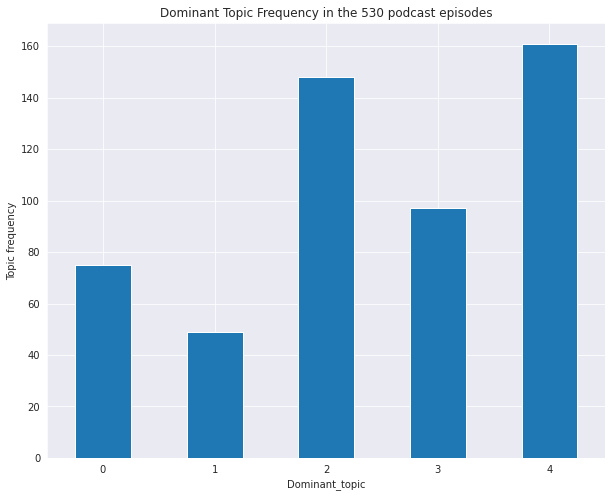

In [31]:
plt.figure(figsize=(10,8))
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Podcast_name'].\
    plot.bar(rot=0).\
    set(title='Dominant Topic Frequency in the {} podcast episodes'.format(len(texts)),
        ylabel='Topic frequency'); 

In [32]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1)])
    
representatives

,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show
15,A Satanist Reads the Bible,The Two Christianities,0,0.999,"[seat, bible, request, request, examination, d...",book chapter daniel history horn human kingdom...,22.00033333333333,A Satanist Reads the Bible
466,The Christian Therapist,Why Do Relationships Fail,1,0.998,"[right, simple, case, anger, plus, creative, r...",body covenant gift grace health holiness relat...,14.9672,Akiami McCoy
371,Lighthouse Church,Welcome Home,2,0.960,"[glad, blessed, spirit, word, alan, mcmillan, ...",amen david house moment money pastor season sp...,0.6404333333333333,Lighthouse Church
60,Brown Girl Bible,Brown Girl Bible Trailer- What is BGB?,3,0.998,"[brown, bible, recommend, tool, record, edit, ...",camp christian experience faith high important...,17.841833333333334,Brown Girl Bible
279,Faith Talks with Emily Preston,041 - You Are The Boss Of The Devil: The Belie...,4,0.999,"[nation, affect, authority, boss, devil, hello...",authority chapter enemy faith heaven power pra...,37.20185,Emily Preston


In [ ]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[2], 
#                                        representatives.loc[representatives.index[2]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[2]]]])

In [33]:
num_topics = best_hp_setting[0]
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [34]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=4), Output()), _dom_classes=('widget-interac…

In [35]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))

Indices of top words: 
{1282, 650, 144, 18, 4882, 2071, 536, 289, 3110, 810, 1450, 557, 3250, 3251, 183, 2618, 1087, 63, 2497, 66, 3647, 200, 1993, 4936, 75, 712, 846, 336, 1106, 1618, 5844, 214, 727, 345, 985, 732, 94, 361, 3698, 114, 502, 503, 4218}



In [36]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [37]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

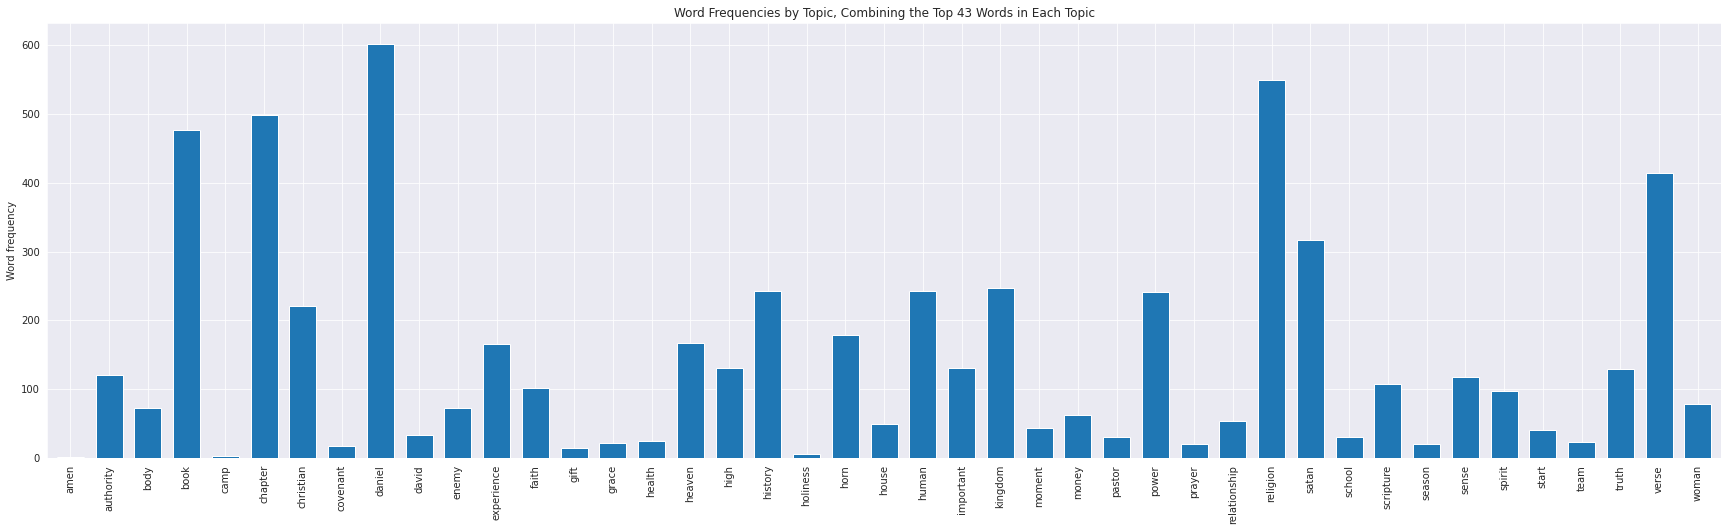

In [38]:
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(0)

clusterwise_words_dist.sum()[:-1].transpose().\
         plot.bar(figsize=(30, 8), width=0.7).\
         set(ylabel='Word frequency', 
         title='Word Frequencies by Topic, Combining the Top {} Words in Each Topic'.format(len(lda_top_words_index)));

In [39]:
word_totals = {k:{y[1]:y[0] for y in x[0]} for k,x in enumerate(top_topics)}

In [40]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=best_hp_setting[0]-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=4), Output()), _dom_classes=('widget-interac…